# Algorithmes quantiques simples

## Deutsch-Josza algorithm

Deutsch's problem: Alice wants to determine whether Bob's function $f(x)$ ($0 \leq x \leq 2^n -1$) is constant (always 0 or always 1) or balanced (0 on half of the entries, 1 on the other half).

$f$ is of course unknown to Alice.


In [1]:
from qat.lang.AQASM import H, X, CNOT, Program, QRoutine

# we first construct the gate corresponding to the oracle
def dj_oracle(constant):
    """ construct quantum routine corresponding
    to Deutsch-Josza's oracle for 2 qubits
    
    Args:
        constant (bool): if true, f is a constant = 0; else, f(00) = f(11) = 0,
            and the rest is 1.
    """
    routine = QRoutine(3) 
    if constant:
        # routine.apply(X, 2) # if constant = 1
        return routine
    # else
    routine.apply(CNOT, 0, 2)
    routine.apply(CNOT, 1, 2)
    return routine

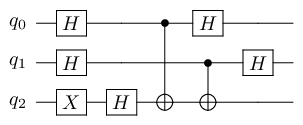

In [2]:
prog = Program()
reg = prog.qalloc(3) # 2 qubits to encode x

X(reg[2])
for qb in range(3):
    H(reg[qb])
prog.apply(dj_oracle(False), reg)
    
for qb in range(2):
    H(reg[qb])
    
circ = prog.to_circ()
%qatdisplay circ

In [3]:
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
job = circ.to_job(nbshots=1, qubits=[0, 1])
res = qpu.submit(job)

In [4]:
for sample in res:
    print(sample.state, sample.probability)

|11> 1.0


Additional question: How to synthesize oracle automatically for any given balanced $f$? 

## Bernstein-Vazirani algorithm

Goal: find bitstring $s$ that appears in definition of function $f(x) = x \cdot s$.

Reminder of the trick: the oracle to realize $\tilde{U}_f$ needs to implement $\tilde{U}_f: |x\rangle \rightarrow (-)^{f(x)} |x\rangle$. To do this, we can use the oracle used for Deutsch-Josza, $ U_f : |x\rangle |y\rangle \rightarrow |x \rangle |y \oplus f(x)\rangle$, with $|y\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$.

Hint: some of the operations you need are already implemented, see: https://myqlm.github.io/qat-lang-arith.html#qat.lang.AQASM.arithmetic.mult_const_mod.

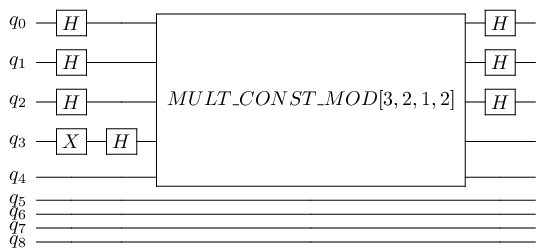

In [5]:
import qat.lang.AQASM.classarith
from qat.lang.AQASM.arithmetic import mult_const_mod

hidden_string = 1 # 

prog = Program()
reg = prog.qalloc(5) # 3 + 2 ancilla

prog.apply(X, reg[3]) # to obtain |0> - |1> on ancilla qubit
for qb in range(4):
    H(reg[qb])

prog.apply(mult_const_mod(3, 2, hidden_string, 2), reg)

for qb in range(3): # on data qubits only
    H(reg[qb])
    
circ = prog.to_circ(link=[qat.lang.AQASM.classarith])
%qatdisplay circ

In [6]:
qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

In [7]:
for sample in res:
    print(sample.state, sample.probability)

|100000000> 0.12499999999999986
|100000100> 0.12499999999999986
|100100000> 0.12499999999999986
|100100100> 0.12499999999999986
|101000000> 0.12499999999999986
|101000100> 0.12499999999999986
|101100000> 0.12499999999999986
|101100100> 0.12499999999999986


For now, there is a problem somewhere.

### Bug in mult_const_mod ?

In [8]:
prog = Program()
reg = prog.qalloc(4) # 3 + 1 ancilla

prog.apply(X, reg[0]) # 3 first qubits 'reg' in state |a> = |100>, i.e 1

prog.apply(X, reg[3]) # 'acc' in state |b> = |10> ??

constant = 3 # i.e |110> 

prog.apply(mult_const_mod(3, 1, constant, 2), reg)
# expecting |a>|b + a c [2]> 
# b + ac = 1 + 1 * 3 = 0 mod 2
# i.e final state should be |100>|0> = |1001>

circ = prog.to_circ(link=[qat.lang.AQASM.classarith])

qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)

IndexError: list index out of range

In [ ]:
prog = Program()
#a, b = prog.qalloc(3), prog.qalloc(3)
reg = prog.qalloc(5)
prog.apply(X, reg[0]) # |100> i.e 1
prog.apply(X, reg[3]) # |100> i.e 1
prog.apply(mult_const_mod(3, 2, 0, 2), reg)
# want to get |a>|b + a c [m]> with a = 1, b = 1, c = 1, m = 2; 1 + 1*1 [2] = 0
# i.e |"1"> |"1"> = |100>|0>
circ = prog.to_circ(link=[qat.lang.AQASM.classarith])

qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)